In [1]:
import os
import sys
import numpy as np
import time
%matplotlib inline
import mpld3
mpld3.enable_notebook()
import matplotlib
import matplotlib.pyplot as plt 

plt.style.use('~/evanstyle.mplstyle')
plt.rcParams['figure.figsize'] = (10.0, 8.0)

## Dictionary of datasets on LLNL. Checks if they exist and how many files
### Note, the integer index of this dictionary matches the row number in the google-spreadsheet log
##### https://docs.google.com/spreadsheets/d/14KmVPS824ExjVpss9H6fMSNVhopGtHVclZNsw5kKLr8/edit?usp=sharing
##### Save this sheet to your own drive!

In [5]:
datatopdir_r1 = "/p/lustre1/angelico/hv-test-chamber/Run1/"
datasets_r1 = {2:"1-29-21/pmt-trig-filling-1800/", \
                3:"1-29-21/pmt-trig-filling-1920/",\
                4:"1-30-21/anode-crosstrig-1300/",\
                6:"1-30-21/ignition-1500/",\
                7:"1-30-21/ignition-10k-1520/",\
                8:"1-31-21/glitch-1520/",\
                9:"2-1-21/anode-100/",\
                10:"2-1-21/anode-1340/",\
                11:"2-1-21/glitch-1530/",\
                12:"2-1-21/glitch-2230/",\
                13:"2-2-21/anode-1030/",\
                14:"2-2-21/corona-1300/",\
                15:"2-2-21/glitch-1320/",\
                16:"2-2-21/glitch-1430/",\
                17:"2-2-21/anode-1720/",\
                18:"2-3-21/glitch-1040/",\
                19:"2-3-21/anode-1050/",\
                20:"2-3-21/glitch-1810/",\
                21:"2-3-21/anode-1820/"}

#check that the datasets are indexible
print("Checking for datasets in top directory: " + datatopdir_r1)
to_remove = [] #list of keys to remove due to not existing
for dno in datasets_r1:
    print(str(dno)+": " + datasets_r1[dno] + "\t\t", end = '')
    isdir = os.path.isdir(datatopdir_r1+datasets_r1[dno]+"/")
    if(isdir):
        numfiles = len([_ for _ in os.listdir(datatopdir_r1+datasets_r1[dno]+"/")])
        print("True, with " + str(numfiles) + " files")
    else:
        print("False")
        to_remove.append(dno)
        

for k in to_remove:
    del datasets_r1[k]
    

datatopdir_r2 = "/p/lustre1/angelico/hv-test-chamber/Run2/"
datasets_r2 = {25:"2-22-21/cosmics-1725/",\
              26:"2-22-21/cosmics-1800/",\
              27:"2-23-21/glitch-1150/",\
              28:"2-23-21/anode-1240/",\
              29:"2-23-21/pmts-1240/",\
              30:"2-23-21/cosmics-1430/",\
              31:"2-23-21/glitch-2000/",\
              32:"2-24-21/glitch-1140/",\
              33:"2-24-21/glitch-1215/",\
              34:"2-24-21/glitch-1425/",\
              35:"2-24-21/anode-1730/",\
              36:"2-25-21/anode-1030/",\
              37:"2-26-21/anode-1430/"}

#check that the datasets are indexible
print("Checking for datasets in top directory: " + datatopdir_r2)
to_remove = [] #list of keys to remove due to not existing
for dno in datasets_r2:
    print(str(dno)+": " + datasets_r2[dno] + "\t\t", end = '')
    isdir = os.path.isdir(datatopdir_r2+datasets_r2[dno]+"/")
    if(isdir):
        numfiles = len([_ for _ in os.listdir(datatopdir_r2+datasets_r2[dno]+"/")])
        print("True, with " + str(numfiles) + " files")
    else:
        print("False")
        to_remove.append(dno)
        

for k in to_remove:
    del datasets_r2[k]
    

Checking for datasets in top directory: /p/lustre1/angelico/hv-test-chamber/Run1/
2: 1-29-21/pmt-trig-filling-1800/		True, with 3019 files
3: 1-29-21/pmt-trig-filling-1920/		True, with 81718 files
4: 1-30-21/anode-crosstrig-1300/		True, with 161 files
6: 1-30-21/ignition-1500/		True, with 3795 files
7: 1-30-21/ignition-10k-1520/		True, with 10849 files
8: 1-31-21/glitch-1520/		True, with 10398 files
9: 2-1-21/anode-100/		True, with 15628 files
10: 2-1-21/anode-1340/		True, with 208 files
11: 2-1-21/glitch-1530/		True, with 5333 files
12: 2-1-21/glitch-2230/		True, with 8129 files
13: 2-2-21/anode-1030/		True, with 22247 files
14: 2-2-21/corona-1300/		True, with 2817 files
15: 2-2-21/glitch-1320/		True, with 14598 files
16: 2-2-21/glitch-1430/		True, with 3364 files
17: 2-2-21/anode-1720/		True, with 21034 files
18: 2-3-21/glitch-1040/		True, with 861 files
19: 2-3-21/anode-1050/		True, with 59444 files
20: 2-3-21/glitch-1810/		True, with 172 files
21: 2-3-21/anode-1820/		True, with 231

## Utility functions for parsing file names

In [6]:

def parse_timestamp_from_filename(infile):
    #infile looks like /path/to/data/file/pmt15.23.43.132.csv (hour, minute, second, milli)
    t = infile.split('/')[-1].split('.')[:-1]
    t[0] = t[0][-2:] #hour is always only two digits, this line just ignores file prefix 
    t = [int(_) for _ in t]
    #now is in form [hours, minutes, seconds, millis]
    milliseconds = t[3] + 1e3*t[2] + 1e3*60*t[1] + 1e3*60*60*t[0]
    return milliseconds

#looks at the input directory (a dataset) and
#finds all .csv files, separating them by file prefix
def get_separated_file_lists(indir, file_prefixes):
    #full list of .csv files
    file_list = [f for f in os.listdir(indir) if \
                 os.path.isfile(os.path.join(indir, f)) \
                 and f.endswith('.csv')]
    separate_file_lists = {}
    for pref in file_prefixes:
        #selects filenames by prefix. so separate_file_lists['pmt'] = ['pmt14.53.24.449', 'pmt10.34....', ...]
        separate_file_lists[pref] = list(filter(lambda x: x[:len(pref)] == pref, file_list))  
        #add the indir to the beginning of each filename so that
        #any file readers know what's up. 
        separate_file_lists[pref] = [indir+_ for _ in separate_file_lists[pref]]
    
    return separate_file_lists

#converts the dictionary of separated file lists into
#a dictionary of separated timestamps (units milliseconds)
def get_separated_timestamps(separated_file_lists):
    separated_timestamps = {}
    for pref in separated_file_lists:
        separated_timestamps[pref] = [parse_timestamp_from_filename(f) for f\
                                      in separated_file_lists[pref]]
       
        #sort both the timestamps lists and the filelists
        #simultaneously by the timestamps
        separated_timestamps[pref], separated_file_lists[pref] = \
        (list(t) for t in zip(*sorted(zip(separated_timestamps[pref], separated_file_lists[pref]))))
    
    return separated_timestamps, separated_file_lists

def get_sampling_period_from_file(infile):
    #parse header for the timestep
    f = open(infile, 'r', errors='ignore')
    ls = f.readlines()
    raw_sample_rate = ls[4]
    raw_sample_rate = raw_sample_rate.split(' ')[-1]
    raw_sample_rate = float(raw_sample_rate.split('H')[0])
    return (1.0/raw_sample_rate)*1e9 #nanoseconds


## PSD calculating functions

In [7]:
from scipy import signal

#input dt in nanoseconds
#frequencies come out in kHz
#psd comes out mV^2/sqrt(kHz)
def get_single_psd_welch(sig, dt):
    samp_freq = (1.0/dt)*(1e6) #First in GHz, then 1e6 brings to kHz
    #freqs output is in kHz, psd is in V^2/sqrt(kHz)
    freqs, psd = signal.welch(sig, samp_freq, scaling='density', nperseg=len(sig))
    psd = psd*1e6 #V^2 to mV^2
    return freqs, psd

def get_single_psd(sig, dt):
    sig = sig*1e3 #V to mV
    psd = np.abs(np.fft.fft(sig))**2
    dt = dt/1.0e6 #ns to uS
    freqs = np.fft.fftfreq(len(sig), dt)
    return freqs, psd

## Load the desired dataset

In [ ]:
import time

#load the dataset

#the part of the filename before the timestamp. 
#used to distinguish the two oscilloscopes
file_prefixes = ["pmt", "anode"]


dataset = datasets_r1[2]

#load dataset
t0 = time.time()
separated_file_lists = get_separated_file_lists(datatopdir_r1+dataset, file_prefixes)
print("Separation by prefix took " + str(time.time() - t0))


## Plot individual PSD side-by-side the event

In [ ]:
import pandas as pd 

#plotting sub-function
def plot_event_psd(event_series, channel):
    fig, ax = plt.subplots(nrows = 2, figsize=(13, 7))
    sig = event_series['Data'][channel]
    dt = event_series['SamplingPeriods'][channel] #nanoseconds
    freqs, psd = get_single_psd(sig, dt)
    
    times = np.arange(0, len(sig)*dt/1000.0, dt/1000.0) #us
    ax[0].plot(times, sig, label="channel " + str(channel))
    ax[0].set_xlabel("time (us)")
    ax[0].set_ylabel("mV")
    
    #samp_freq = (1.0/dt)*(1e6) #First in GHz, then 1e6 brings to kHz
    #ax[1].psd(sig, Fs=samp_freq, NFFT=len(times), pad_to=len(times))
    freqs, psd = get_single_psd_welch(sig, dt)
    ax[1].plot(freqs, psd)
    ax[1].set_yscale('log')
    ax[1].set_xlabel("frequency (kHz)")
    ax[1].set_ylabel("power spectral density" +  '(mV^2 /sqrt(kHz))')
    
    plt.tight_layout()
    plt.show()
    
    

In [ ]:
import random
import pandas as pd
#which channel do you want?
file_prefix = "anode" 
file_channel = 1 #column for the channel selection
nevents = 1 #how many to plot
maxevts = len(separated_file_lists[file_prefix])#max events in dataset
for i in range(nevents):
    infile = random.choice(separated_file_lists[file_prefix])
    event_series = pd.Series()
    event_series['Timestamps'] = [parse_timestamp_from_filename(infile)]*2 #in milliseconds since 00:00 (midnight)
    
    event_series['SamplingPeriods'] = [get_sampling_period_from_file(infile)]*2 #nanoseconds
    
    #load the file
    d = pd.read_csv(infile, header=None, skiprows=20, names=['ts','0','1'], encoding='iso-8859-1')
    event_series['Channels'] = ["glitch", "anode"]
    event_series['ChannelTypes'] = ["glitch", "anode"]
    data_map = [d['0'].to_numpy(), d['1'].to_numpy()] 
    event_series['Data'] = data_map
    
    plot_event_psd(event_series, file_channel)
    

## Average many spectral densities event-by-event

In [ ]:
import random
import pandas as pd
import pickle
#which channel do you want?
file_prefix = "anode" 
file_channel = 1 #column for the channel selection
nevents = 50 #how many to plot
maxevts = len(separated_file_lists[file_prefix])#max events in dataset
ave_psd = []
ave_freqs = []
for i in range(nevents):
    infile = random.choice(separated_file_lists[file_prefix])
    print("on event " + infile)
    event_series = pd.Series()
    event_series['Timestamps'] = [parse_timestamp_from_filename(infile)]*2 #in milliseconds since 00:00 (midnight)
    
    event_series['SamplingPeriods'] = [get_sampling_period_from_file(infile)]*2 #nanoseconds
    
    #load the file
    d = pd.read_csv(infile, header=None, skiprows=20, names=['ts','0','1'], encoding='iso-8859-1')
    event_series['Channels'] = ["glitch", "anode"]
    event_series['ChannelTypes'] = ["glitch", "anode"]
    data_map = [d['0'].to_numpy(), d['1'].to_numpy()] 
    event_series['Data'] = data_map
    
    sig = event_series['Data'][file_channel]
    dt = event_series['SamplingPeriods'][file_channel] #nanoseconds
    freqs, psd = get_single_psd_welch(sig, dt)
    #freqs always come back the same for identically channeled events
    if(len(ave_freqs) == 0): 
        ave_freqs = freqs
        ave_psd = psd
        continue
    ave_psd = [ave_psd[i] + psd[i] for i in range(len(psd))] 

    
pickle.dump([ave_freqs, ave_psd], open("./"+dataset.replace("/", '_')+"_psdaverage_"+str(nevents)+"evts.p", "wb"))

ave_psd = list(np.array(ave_psd)/float(nevents))    
fig, ax = plt.subplots()
ax.plot(ave_freqs, ave_psd)
ax.set_yscale('log')
plt.show()

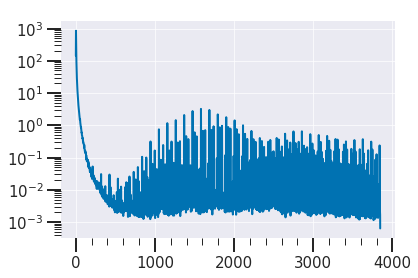

In [19]:
import random
import pandas as pd
import pickle
ave_freqs, ave_psd = pickle.load(open("2-1-21_anode-1340__psdaverage_50evts.p", "rb"))
fig, ax = plt.subplots()
ax.plot(ave_freqs, ave_psd)
ax.set_yscale('log')
plt.show()